# Graph Experiment 2 bot

In [1]:
%load_ext autoreload
%autoreload 2

## Capture code as strings
We collect code from chosen cells as strings, and place them in nodes in the graph. The code is intended to be sufficient to reproduce the results.

In [2]:
code_strings = []

In [3]:
import numpy as np
from nnbench import NetMaker, NNMEG
import time
import tools.neotools as nj

In [4]:
code_strings.append(In[-2]) # Grab the cell above

In [5]:
import neo4j

## Connecting

Need to get the `gpu-jupyter` and the `neo4j` docker containers connected. If run bare, something like:

    docker network connect gpu-jupyter_default gpu-jupyter 
    docker network connect gpu-jupyter_default neo4j
    docker network inspect gpu-jupyter_default 
    
Docker has better ways than this.

In [6]:
driver = neo4j.GraphDatabase.driver("neo4j://172.19.0.2:7687", auth=("neo4j", "test"))

In [7]:
driver.verify_connectivity()

<ipython-input-7-b734c674563a>:1: ExperimentalWarning: The configuration may change in the future.
  driver.verify_connectivity()


{IPv4Address(('172.19.0.2', 7687)): [{'ttl': 300,
   'servers': [{'addresses': ['172.19.0.2:7687'], 'role': 'WRITE'},
    {'addresses': ['172.19.0.2:7687'], 'role': 'READ'},
    {'addresses': ['172.19.0.2:7687'], 'role': 'ROUTE'}]}]}

# The graph database

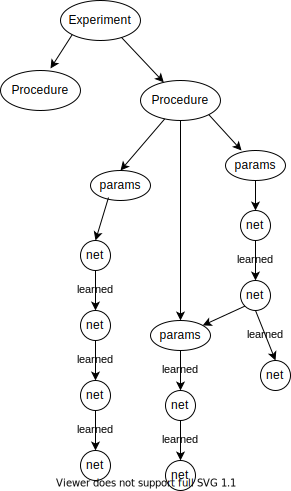

In [8]:
from IPython.display import SVG, display
display(SVG('ml graphdb structure r2.svg'))

# Prepare code for later `eval`

## Create the net we will train

In [9]:
mnm = NetMaker(NNMEG)
net = mnm('1x8tx8tx3tx3t')

def adc(input):
    m = max(0, min(7, int(8*input)))
    return np.array([(m>>2)&1, (m>>1)&1, m&1]) * 2 - 1

vadc = lambda v: np.array([adc(p) for p in v])

x = np.arange(0, 1, 1.0/(8*8)).reshape(-1,1) # 8 points in each output region
training_batch = (x, vadc(x))

In [10]:
code_strings.append(In[-2])

## First net node

In [11]:
def add_start(driver, facts):
    q = """
MERGE (:net 
  {shorthand: $shorthand,
         ksv: $ksv,
        loss: $loss,
          ts: $ts,
  experiment: $experiment,
        head: $head})
"""
    nj.query_write(driver, q, **facts)

In [12]:
code_strings.append(In[-2])

## Trained net nodes

In [13]:
def add_subsequent(driver, facts):
    q = """
MATCH (a:net {ksv: $prior_ksv})
MERGE (a)-[:LEARNED
         {batch_points: $batch_points,
                  etas: $etas,
    eta_change_batches: $eta_change_batches,
  batches_this_segment: $batches_this_segment,
                losses: $loss,
            loss_steps: $loss_step,
           traj_L2_sqs: $traj_L2_sq,
   traj_cos_sq_signeds: $traj_cos_sq_signed,
                    ts: $ts}]->
(b:net
  {shorthand: $shorthand,
         ksv: $ksv,
        loss: $end_loss,
          ts: $ts,
  experiment: $experiment})
"""
    nj.query_write(driver, q, **facts)

In [14]:
code_strings.append(In[-2])

## Train, recording trajectory

In [15]:
def trainer(net, nps):
    loss = net.losses([training_batch])[0]
    batch_ctr = 0
    while loss > 1e-3:
        batch_ctr_at_seg_start = batch_ctr
        losses = []
        etas = []
        deltas = []
        prior_loss = loss
        while loss / prior_loss > 0.7071 and len(deltas) < 100:
            if not etas or net.eta != etas[-1][1]:
                etas.append([batch_ctr, net.eta])
            loss = net.learn([training_batch])
            if batch_ctr < 100 or batch_ctr % 100 == 0:
                losses.append([batch_ctr, loss])
                deltas.append([batch_ctr, net.deltas()])
            batch_ctr += 1
        #if losses[-1][0] < (batch_ctr-1):
        #    losses.append([batch_ctr, loss])
        if not deltas or deltas[-1][0] < (batch_ctr-1):
            deltas.append((batch_ctr, net.deltas()))
        properties = dict(zip(deltas[0][1]._fields, map(list, (zip(*(v[1] for v in deltas))))))
        #properties = {}
        properties['batch_points'] = [v[0] for v in deltas]
        #properties['etas'] = etas
        properties['etas'], properties['eta_change_batches'] = (list(v) for v in zip(*etas))
        properties['batches_this_segment'] = batch_ctr - batch_ctr_at_seg_start
        properties['ts'] = time.time()
        properties['shorthand'] = net.shorthand
        properties['ksv'] = nps.store(net.state_vector())
        properties['end_loss'] = net.losses([training_batch])[0]
        properties['experiment'] = 'ADC'
        yield properties

In [16]:
code_strings.append(In[-2])

In [17]:
def get_starting_facts(net, nps):
    rv = {'shorthand': net.shorthand,
          'ksv': nps.store(net.state_vector()),
          'loss': net.losses([training_batch])[0],
          'ts': time.time(),
          'experiment': 'ADC',
          'head': True,
         }
    return rv

In [18]:
code_strings.append(In[-2])

## Build the runner

In [19]:
def create_starting_entry(driver, net, nps, get_starting_facts, q_add_start):
    starting_facts = get_starting_facts(net, nps)
    tj.query_write(driver, q_add_start, **starting_facts)
    return starting_facts['ksv']

In [20]:
code_strings.append(In[-2])

In [21]:
def extend_by_one(driver, net, ksv, nps, observations, add_subsequent):
    with driver.session() as session:
        session.write_transaction(add_subsequent, observations, net)
        print(f"loss {observations['end_loss']}")
        return observations['ksv']

In [22]:
code_strings.append(In[-2])

In [23]:
def run_it(cx, driver, nps):
    net = cx['net']
    add_start = cx['add_start']
    add_subsequent = cx['add_subsequent']
    get_starting_facts = cx['get_starting_facts']
    trainer = cx['trainer']

    with driver.session() as session:
        starting_facts = get_starting_facts(net, nps)
        add_start(driver, starting_facts)
        prior_ksv = starting_facts['ksv']
        for observations in trainer(net, nps):
            observations['prior_ksv'] = prior_ksv
            prior_ksv = observations['ksv']
            add_subsequent(driver, observations)
            print(f"loss {observations['end_loss']}")

In [24]:
code_strings.append(In[-2])

* https://neo4j.com/docs/cypher-manual/current/clauses/match/

# Create the Experiment -> Procedure -> Parameters
Create an experiment, add a procedure, add parameters.

## Methods to create/merge

In [25]:
def add_a_procedure(driver, **kwargs):
    q = """
MERGE (e:Experiment {name: $experiment_name})
-[:includes]->
(:Procedure {name: $procedure_name,  code_strings: $code_strings})
"""
    nj.query_write(driver, q, **kwargs)

In [26]:
def add_parameters_to_experiment_procedure(driver, **kwargs):
    q = """
MATCH (e:Experiment {name: $experiment_name})
-[:includes]->
(proc:Procedure {name: $procedure_name})
MERGE (proc)-[:incorporates]->
(par:Parameters {name: $parameters_name, code_strings: $code_strings})
"""
    nj.query_write(driver, q, **kwargs)

In [27]:
def get_code_strings_of_experiment_procedure_parameters(driver, **kwargs):
    q = """
MATCH (e:Experiment {name: $experiment_name})
-[:includes]->
(proc:Procedure {name: $procedure_name})
-[:incorporates]->
(par:Parameters {name: $parameters_name})
RETURN proc.code_strings, par.code_strings
"""
    records = nj.query_read_return_list(driver, q, **kwargs)
    assert len(records) == 1
    r = records[0]
    return r['proc.code_strings'] + r['par.code_strings']

# Experiment setup

In [28]:
add_a_procedure(driver,
    experiment_name='t2',
    procedure_name='Train ADCs',
    code_strings=code_strings)

In [29]:
add_parameters_to_experiment_procedure(driver,
    experiment_name='t2',
    procedure_name='Train ADCs',
    parameters_name='go easy',
    code_strings=['net.eps = 0.02'])

# Here the experiment is set up in the graph
Now we go get the code out of the graph, and run the experiment

In [30]:
code_strings = get_code_strings_of_experiment_procedure_parameters(driver,
    experiment_name='t2',
    procedure_name='Train ADCs',
    parameters_name='go easy')

In [32]:
assert False, "pause here"

AssertionError: pause here

In [33]:
cx = {}
for s in code_strings:
    exec(s, cx)

In [ ]:
nps = nj.NumpyStore(driver)
cx['run_it'](cx, driver, nps)

loss 1.888340530259108
loss 1.3274874044062455
loss 0.9401800886163793
loss 0.6614851229641336
loss 0.4710859877141814
loss 0.43463676725049577
loss 0.39708268206813285
loss 0.38673411737584396
loss 0.3821920293085722
loss 0.37808100605910033
loss 0.3696738474022254
loss 0.5480588824100325
loss 0.36339391752340966
loss 0.36159450310746255
loss 0.3595418699222799
loss 0.36039378391941146
loss 0.35617655610995985
loss 0.46178298457058675
loss 0.3620653679108005
loss 0.3647175528481555
loss 0.355627675516816
loss 0.3628954085114562
loss 0.35200620505241775
loss 0.6315403023295119
loss 0.3512165845408976
loss 0.350671383094424
loss 0.3562987150856445
loss 0.3591088897755154
loss 0.35086226174730933
loss 0.34853352534484705
loss 0.3630995194963636
loss 0.3492993445348237
loss 0.347572144253928
loss 0.3515510139810899
loss 0.3531178860922698
loss 0.34626382577022097
loss 0.34710499881811113
loss 0.36136269257574183
loss 0.36557171975930947
loss 0.3537860981332007
loss 0.35412362874336634
los

In [ ]:
assert False, "pause here"

In [ ]:
cx = {}
for s in code_strings:
    exec(s, cx)

In [ ]:
cx.keys()

In [ ]:
cx['a'], cx['foo'](3), cx['b'], cx['bar'](3)

In [ ]:
assert False, "wait here"

In [ ]:
def tx_add_start_net(tx, starting_facts, net):
    tx.run("MATCH (proc:Procedure)")

In [ ]:
def add_subsequent(tx, facts, net):
    tx.run("MATCH (a:net {ksv: $prior_ksv}) "
           "MERGE (a)-"
           "[:LEARNED "
               "{batch_points: $batch_points, "
               "etas: $etas, "
               "eta_change_batches: $eta_change_batches, "
               "batches_this_segment: $batches_this_segment, "
               "losses: $loss, "
               "loss_steps: $loss_step, "
               "traj_L2_sqs: $traj_L2_sq, "
               "traj_cos_sq_signeds: $traj_cos_sq_signed, "
               "ts: $ts "
               "}]->"
           "(b:net "
               "{shorthand: $shorthand, "
               "ksv: $ksv, "
               "loss: $end_loss, "
               "ts: $ts, "
               "experiment: $experiment}) ",
           **facts)

In [ ]:
outer_cx = dict(driver=driver, nps=NumpyStore(driver))

In [ ]:
cx['make_start'](outer_cx) # make the starting net node

In [ ]:
while cx['wants_more_learning'](net, obs):
    net, obs = cx['train_to_checkpoint'](net, obs, outer_cx)
    cx['append_to_run'](net, obs, outer_cx)

In [ ]:
assert False, "stop"

In [ ]:
def tx_get_tst(tx, cb, **kwargs):
    for rec in tx.run("""
MATCH (n:dot)
RETURN n
""", **kwargs):
        cb(rec)

In [ ]:
def tx_get_tst(tx, **kwargs):
    for record in tx.run("""
MATCH (e:Experiment {name: $experiment_name})
RETURN e, 'cat'
    """, **kwargs):
        print(record)

In [ ]:
with driver.session() as session:
    session.read_transaction(tx_get_tst, experiment_name='t1')

In [ ]:
def do_a_read_tx(driver, tx_fun, cb, **kwargs):
    with driver.session() as session:
        return session.read_transaction(tx_fun, cb, **kwargs)

In [ ]:
def do_a_write_tx(driver, tx_fun, cb, **kwargs):
    with driver.session() as session:
        session.write_transaction(tx_fun, cb, **kwargs)

In [ ]:
net = cx['net']
add_start = cx['add_start']
add_subsequent = cx['add_subsequent']
starting_facts = cx['starting_facts']
trainer = cx['trainer']

with driver.session() as session:
    session.write_transaction(add_start, starting_facts, net)
    prior_ksv = starting_facts['ksv']
    for observations in trainer(net):
        observations['prior_ksv'] = prior_ksv
        prior_ksv = observations['ksv']
        #pprint(observations)
        #observations['etas'] = observations['etas'][0] #DEBUG HACK, FIXME
        session.write_transaction(add_subsequent, observations, net)
        print(f"loss {observations['end_loss']}")

## An example experiment's DAG

In [ ]:
randomize_net(net)

In [ ]:
net.eta = 0.02

In [ ]:
nps = nj.NumpyStore(driver)